# PLAN

 - Диалоговый датасет
     - BANKING77
     - CLINC150
     - HWU64
     - https://github.com/google-research-datasets/dstc8-schema-guided-dialogue
 - Генератор (XLM-R)
     - придумать как генерировать токен на другом языке
     - применить к задачке
 - LABSE для полученных и исходных предложений
     - сделать кастомный класс лосса

 - Пообучать языковую модель на частичных переводах ?
 - думать

Для XLM-R:

Занулить веса на выходе для всех языков кроме русского (пройтись по всем токенам и регулярочкой выявить те токены, которые относятся к русскому). Перед backward занулять градиенты по всем токенам не из русского, ибо торч не даст ставить requires_grad на отдельную часть тензора.

Как вариант - написать обертку над моделью, которая будет иметь меньший размер выходной головы, потом делать новый тензор с нулями на месте других языков и выходом модели для русского.

In [2]:
import json
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch

import sys

sns.set(style='darkgrid', rc={'figure.figsize': (16, 9)})
sys.path.append('..')

In [3]:
with open('../data/dstc_utterances.json') as f:
    data = json.load(f)

texts, intents = zip(*((elem['text'], elem['intent']) for elem in data))

len(texts), len(np.unique(intents))

(61767, 46)

In [20]:
lens = np.array([len(text.split()) for text in texts])

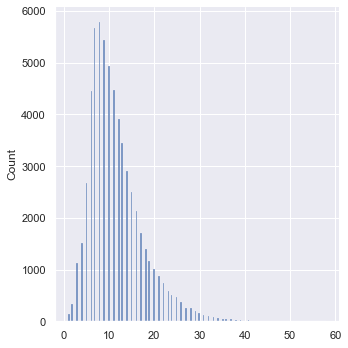

In [21]:
sns.displot(lens)
plt.show()

In [6]:
import torch
import torch.nn.functional as func

from transformers import (
    PretrainedConfig,
    XLMRobertaForMaskedLM,
    XLMRobertaModel,
    XLMRobertaTokenizerFast,
)


model = XLMRobertaModel(PretrainedConfig.from_json_file(f'../models/xlm-roberta-base-mean-tokens.json'))
model.load_state_dict(torch.load('../models/xlm-roberta-base-mean-tokens.pth'))

model.to('cuda:0')

model.eval();

In [9]:
tokenizer = XLMRobertaTokenizerFast.from_pretrained('xlm-roberta-base')

In [10]:
import regex

def is_cyrillic(s: str):
    return bool(regex.search(r'\p{IsCyrillic}', s))


russian_tokens_mask = np.zeros(model.embeddings.word_embeddings.weight.shape[0])

for token in range(len(russian_tokens_mask)):
    if is_cyrillic(tokenizer.decode([token])):
        russian_tokens_mask[token] = 1

russian_tokens_mask = russian_tokens_mask.astype(bool)

In [23]:
np.array(texts)[lens > 30][0]

'I am bored of eating food from home , i need a change . Will you find me a place to eat? It can be costly priced and i am very fond of it'

In [28]:
with torch.no_grad():

    sentence = np.array(texts)[lens > 30][0]

    encoding = tokenizer.encode(sentence, return_tensors='pt').to('cuda:0')

    embedding = func.normalize(model(encoding).pooler_output, p=2)

In [31]:
tokenizer.decode(encoding[0][7])

'food'

In [32]:
from tqdm import tqdm

results = {}

with torch.no_grad():

    for token in tqdm(np.arange(0, len(russian_tokens_mask))[russian_tokens_mask]):
        encoding[0][7] = token

        new_embedding = func.normalize(model(encoding).pooler_output, p=2)

        results[tokenizer.decode([token])] = (embedding @ new_embedding.transpose(0, 1)).item()

100%|██████████| 31671/31671 [03:49<00:00, 138.23it/s]


In [35]:
for key in sorted(results, key=lambda x: -results[x])[:100]:
    print(key, results[key])

храната 0.9978576898574829
работите 0.9977532029151917
врсте 0.9977286458015442
обзавеждане 0.9975391030311584
вещи 0.9975258708000183
учесници 0.9974690079689026
зүйлс 0.9974520206451416
обробки 0.9974477291107178
байгууллагуудын 0.9974027872085571
долбоор 0.9973726272583008
фарма 0.9973312616348267
вещей 0.9972776174545288
власний 0.9972649216651917
ствари 0.9972629547119141
динг 0.9972625374794006
Продукт 0.9972578883171082
нинг 0.997209906578064
материјала 0.9971902370452881
ястия 0.9971784353256226
работата 0.9971710443496704
матеріалів 0.997165858745575
хөдөлмөрийн 0.9971568584442139
членів 0.997153639793396
дызайн 0.9971397519111633
дисциплін 0.9970869421958923
съдържанието 0.9970850348472595
радови 0.9970662593841553
калектыў 0.9970532655715942
кинг 0.9970251321792603
зберігання 0.9970059394836426
нийтийн 0.9970053434371948
Матеріали 0.9970045685768127
материјали 0.9969939589500427
инг 0.9969924688339233
материалы 0.9969918727874756
уреди 0.9969720244407654
трен 0.9969700574874

In [6]:
model_name = 'sentence-transformers/xlm-r-100langs-bert-base-nli-mean-tokens'
model = AutoModel.from_pretrained(model_name)

In [7]:
torch.save(model.state_dict(), '../models/xlm-roberta-base-mean-tokens.pth')

In [21]:
model.config.to_json_file('../models/xmr-roberta-base-mean-tokens.json')

In [104]:
from transformers import XLMRobertaModel, PretrainedConfig

model = XLMRobertaModel(PretrainedConfig.from_json_file('../models/xlm-roberta-base-mean-tokens.json'))

In [105]:
model.load_state_dict(torch.load('../models/xlm-roberta-base-mean-tokens.pth'))

<All keys matched successfully>

In [106]:
model

XLMRobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(250002, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0): RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): 

In [81]:
loss = CustomLoss(torch.device('cuda:0'))

In [82]:
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

In [120]:
inputs = tokenizer.encode("I went fishing and I caught several big fish", return_tensors='pt')

model.embeddings(inputs)

tensor([[[-0.0416,  0.0110, -0.0000,  ...,  0.0000, -0.1096, -0.0141],
         [ 0.0631, -0.6998, -0.5704,  ..., -0.1152, -0.4210,  0.5102],
         [-0.1585,  0.0000, -0.7146,  ...,  0.6517,  0.3447, -0.1969],
         ...,
         [-0.0000, -0.1132, -0.4343,  ...,  1.0054, -0.0928, -0.0329],
         [ 0.1366,  0.8943,  0.0611,  ...,  0.0495, -0.3360, -0.6585],
         [ 0.0166,  0.1572,  0.0089,  ...,  0.0337,  0.0542, -0.1161]]],
       grad_fn=<MulBackward0>)

In [121]:
inputs = inputs.reshape(-1, 1)

tokens_one_hot = torch.zeros(inputs.shape[0], 250002).scatter_(
    1, inputs, 1.0
)

In [122]:
model.embeddings.forward(inputs_embeds=(tokens_one_hot @ model.embeddings.word_embeddings.weight).unsqueeze(0))

tensor([[[-0.0416,  0.0000, -0.0678,  ...,  0.0280, -0.1096, -0.0141],
         [ 0.0631, -0.6998, -0.5704,  ..., -0.1152, -0.4210,  0.5102],
         [-0.1585,  0.4480, -0.7146,  ...,  0.6517,  0.3447, -0.1969],
         ...,
         [-0.8030, -0.1132, -0.4343,  ...,  1.0054, -0.0928, -0.0329],
         [ 0.1366,  0.8943,  0.0611,  ...,  0.0000, -0.3360, -0.6585],
         [ 0.0166,  0.1572,  0.0089,  ...,  0.0337,  0.0542, -0.1161]]],
       grad_fn=<MulBackward0>)

In [124]:
torch.allclose(model.embeddings(inputs), model.embeddings.forward(inputs_embeds=(tokens_one_hot @ model.embeddings.word_embeddings.weight).unsqueeze(0)))

False

In [134]:
model.eval()

with torch.no_grad():
    inputs = tokenizer.encode("I went fishing and I caught several big fish", return_tensors='pt')
    
    x = model.embeddings(inputs)
    
    inputs = tokenizer.encode("I went fishing and I caught several big fish", return_tensors='pt').reshape(-1, 1)

    tokens_one_hot = torch.zeros(inputs.shape[0], 250002).scatter_(
        1, inputs, 1.0
    )
    
    y = model.embeddings.forward(inputs_embeds=(tokens_one_hot @ model.embeddings.word_embeddings.weight).unsqueeze(0))
    
    

In [135]:
x.shape

torch.Size([1, 12, 768])

In [136]:
y.shape

torch.Size([1, 12, 768])

In [137]:
torch.mean((x == y).float())

tensor(1.)